In [2]:
import himalaya.scoring
import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, GroupRidgeCV

from dataset import generate_dataset

In [12]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord-light-talk')

In [14]:
d_list = [100, 100, 100]
# scalars = [1 / 3, 1 / 2, 1 / 6]
scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

In [5]:
alphas = np.logspace(-5, 5, 10)
cv = 5
score_func = himalaya.scoring.r2_score

In [29]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_scalar)

train joint model

In [30]:
banded_solver_params = dict(n_iter=5, alphas=alphas, warn=False, score_func=score_func, n_targets_batch=1000)
joint_model = GroupRidgeCV(groups="input", solver_params=banded_solver_params)

In [31]:
joint_model.fit([x[:n_samples_train] for x in Xs], Y[:n_samples_train])
joint_score = joint_model.score([x[n_samples_train:] for x in Xs], Y[n_samples_train:])
joint_score = backend.to_numpy(joint_score)

[........................................] 100% | 9.50 sec | 5 random sampling with cv | 


Text(0.8912497162818909, 0, '0.89')

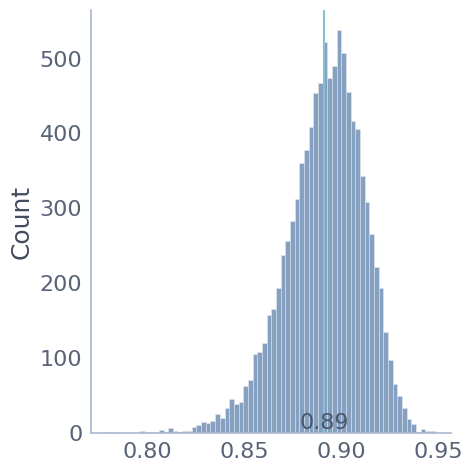

In [32]:
sns.displot(joint_score)
plt.axvline(joint_score.mean(), label="mean", color="C1")
plt.text(joint_score.mean(), 0, f"{joint_score.mean():.2f}", ha='center', va='bottom')

train single models

In [33]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
single_model.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
score_0 = single_model.score(Xs[0][n_samples_train:], Y[n_samples_train:])
score_0 = backend.to_numpy(score_0)

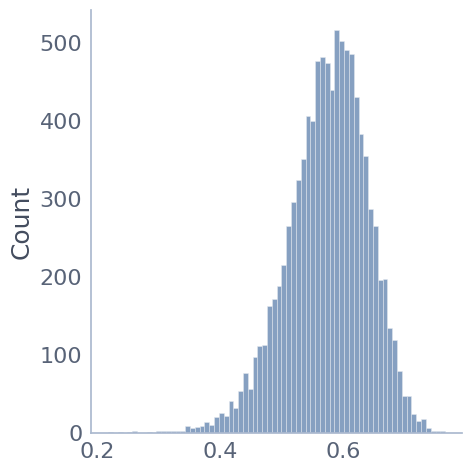

In [34]:
sns.displot(score_0)

In [35]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
single_model.fit(Xs[1][:n_samples_train], Y[:n_samples_train])
score_1 = single_model.score(Xs[1][n_samples_train:], Y[n_samples_train:])
score_1 = backend.to_numpy(score_1)

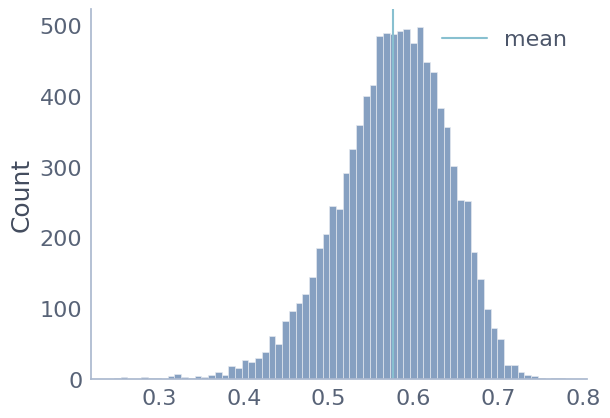

In [36]:
sns.histplot(score_1)
plt.axvline(score_1.mean(), label="mean", color="C1")
plt.legend()

Calculate unique and shared variance

In [37]:
shared = (score_0 + score_1) - joint_score
x0_unique = score_0 - shared
x1_unique = score_1 - shared

In [38]:
shared = backend.to_numpy(shared)
x0_unique = backend.to_numpy(x0_unique)
x1_unique = backend.to_numpy(x1_unique)

create pandas dataset of all scores for analysis

In [15]:
import os

path = os.path.join('results', f'variance_partitioning_{scalars}.csv')
if not os.path.exists(path):
    scores = pd.DataFrame()
    scores[r"$(X_1\cup X_2)\beta \approx Y$"] = joint_score
    scores[r"$X_1\beta \approx Y$"] = score_0
    scores[r"$X_2\beta \approx Y$"] = score_1
    scores[r"$R^2(X_1\beta \approx Y)\cap R^2(X_2\beta \approx Y)$"] = shared
    scores[r"$R^2(X_1\beta \approx Y) \setminus R^2(X_2\beta \approx Y)$"] = x0_unique
    scores[r"$R^2(X_2\beta \approx Y) \setminus R^2(X_1\beta \approx Y)$"] = x1_unique
    scores.to_csv(path)
else:
    scores = pd.read_csv(path)

scores.head()

,Unnamed: 0,$(X_1\cup X_2)\beta \approx Y$,$X_1\beta \approx Y$,$X_2\beta \approx Y$,$R^2(X_1\beta \approx Y)\cap R^2(X_2\beta \approx Y)$,$R^2(X_1\beta \approx Y) \setminus R^2(X_2\beta \approx Y)$,$R^2(X_2\beta \approx Y) \setminus R^2(X_1\beta \approx Y)$
0,0,0.897115,0.563241,0.566870,0.232996,0.330245,0.333874
1,1,0.876583,0.551462,0.590798,0.265677,0.285785,0.325121
2,2,0.939508,0.621310,0.682613,0.364414,0.256895,0.318199
3,3,0.901428,0.580008,0.637032,0.315613,0.264396,0.321420
4,4,0.902166,0.525270,0.539063,0.162166,0.363104,0.376897


In [16]:
renamed_scores = pd.DataFrame()
renamed_scores["A,B,C"] = scores[r"$(X_1\cup X_2)\beta \approx Y$"]
renamed_scores[r"A,B"] = scores[r"$X_1\beta \approx Y$"]
renamed_scores[r'A,C'] = scores[r"$X_2\beta \approx Y$"]
renamed_scores[r"A"] = scores[r"$R^2(X_1\beta \approx Y)\cap R^2(X_2\beta \approx Y)$"]
renamed_scores[r"B"] = scores[r"$R^2(X_1\beta \approx Y) \setminus R^2(X_2\beta \approx Y)$"]
renamed_scores[r"C"] = scores[r"$R^2(X_2\beta \approx Y) \setminus R^2(X_1\beta \approx Y)$"]

renamed_scores.head()

,"A,B,C","A,B","A,C",A,B,C
0,0.897115,0.563241,0.566870,0.232996,0.330245,0.333874
1,0.876583,0.551462,0.590798,0.265677,0.285785,0.325121
2,0.939508,0.621310,0.682613,0.364414,0.256895,0.318199
3,0.901428,0.580008,0.637032,0.315613,0.264396,0.321420
4,0.902166,0.525270,0.539063,0.162166,0.363104,0.376897


Text(0.5, 0, 'Feature Space(s)')

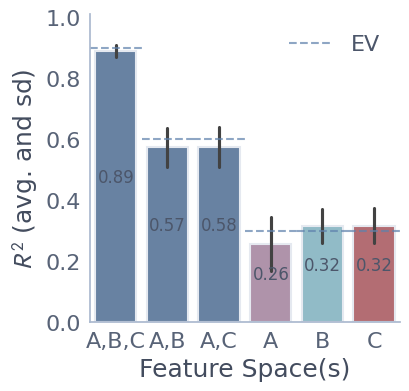

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    data=renamed_scores,
    palette=["C0", "C0", "C0", "C4", "C1", "C3"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax,
    errorbar='sd',
)
sns.despine(fig)
theoretical_scores = [
    sum(scalars),
    (scalars[0] + scalars[1]),
    (scalars[0] + scalars[2]),
    scalars[0],
    scalars[1],
    scalars[2]
]
theoretical_scores = np.array(theoretical_scores) * (1 - noise_scalar)

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(renamed_scores.columns):  # iterate over rows in the DataFrame
    xmin = idx / len(renamed_scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(renamed_scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, color='C0',
                xmin=xmin, xmax=xmax, label=fr'EV' if idx == 0 else "")
    plt.text(idx, renamed_scores[column].mean() / 2, f"{renamed_scores[column].mean():.2f}", ha='center', va='bottom',
             fontsize=12)

plt.xticks(range(len(renamed_scores.columns)), renamed_scores.columns, )

plt.ylim(0, 1.01)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"$R^2$ (avg. and sd)")
plt.xlabel(r"Feature Space(s)")

In [18]:
simple_scores = pd.DataFrame()
simple_scores[r"$X_1\cup X_2$"] = scores[r"$(X_1\cup X_2)\beta \approx Y$"]
simple_scores[r"$X_1$"] = scores[r"$X_1\beta \approx Y$"]
simple_scores[r"$X_2$"] = scores[r"$X_2\beta \approx Y$"]

Text(0.5, 0, 'Feature Space')

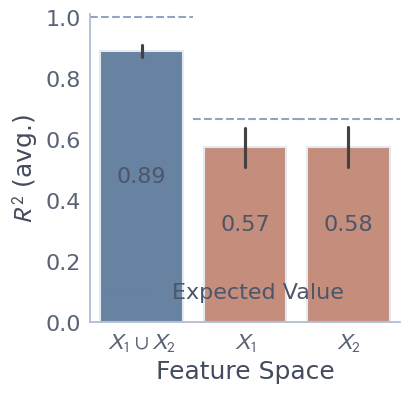

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    data=simple_scores,
    palette=["C0", "C2", "C2"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax,
    errorbar='sd',
)
sns.despine(fig)
theoretical_scores = [
    sum(scalars),
    scalars[0] + scalars[1],
    scalars[0] + scalars[2],
]

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(simple_scores.columns):  # iterate over rows in the DataFrame
    xmin = idx / len(simple_scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(simple_scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, color='C0',
                xmin=xmin, xmax=xmax, label=fr'Expected Value' if idx == 0 else "")
    plt.text(idx, simple_scores[column].mean() / 2, f"{simple_scores[column].mean():.2f}", ha='center', va='bottom')

plt.xticks(range(len(simple_scores.columns)), simple_scores.columns)

plt.ylim(0, 1.01)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"$R^2$ (avg.)")
plt.xlabel(r"Feature Space")
# plt.title("Variance Partitioning")

Text(0.5, 0, 'Feature Space')

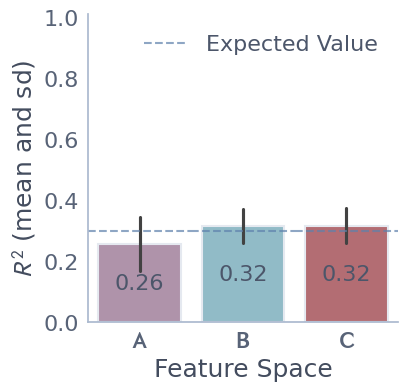

In [20]:
vp_scores = pd.DataFrame()

vp_scores[r'$\mathbf{A}$'] = scores[r"$R^2(X_1\beta \approx Y)\cap R^2(X_2\beta \approx Y)$"]
vp_scores[r"$\mathbf{B}$"] = scores[r"$R^2(X_1\beta \approx Y) \setminus R^2(X_2\beta \approx Y)$"]
vp_scores[r"$\mathbf{C}$"] = scores[r"$R^2(X_2\beta \approx Y) \setminus R^2(X_1\beta \approx Y)$"]

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    data=vp_scores,
    palette=["C4", "C1", "C3"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax,
    errorbar='sd',
)
sns.despine(fig)
theoretical_scores = np.array([
    scalars[0],
    scalars[1],
    scalars[2],
]) * (1 - noise_scalar)

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(vp_scores.columns):  # iterate over rows in the DataFrame
    xmin = idx / len(vp_scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(vp_scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, color='C0',
                xmin=xmin, xmax=xmax, label=fr'Expected Value' if idx == 0 else "")
    plt.text(idx, vp_scores[column].mean() / 2, f"{vp_scores[column].mean():.2f}", ha='center', va='center')

# plt.xticks(range(len(vp_scores.columns)), vp_scores.columns)


plt.ylim(0, 1.01)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"$R^2$ (mean and sd)")
plt.xlabel(r"Feature Space")
# plt.title("Variance Partitioning")

Text(0.0, 1.0, 'Variance Partitioning')

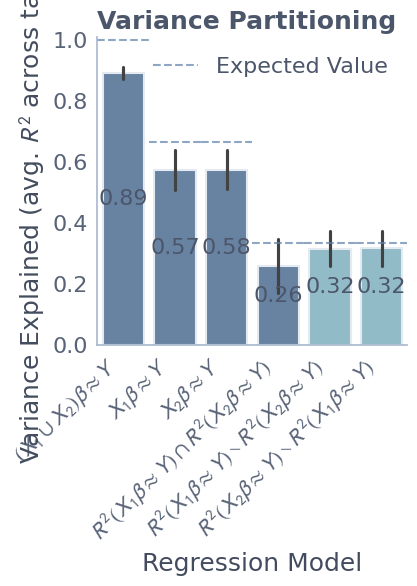

In [45]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    data=scores,
    palette=["C0", "C0", "C0", "C0", "C1", "C1"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax,
    errorbar='sd',
)
sns.despine(fig)
theoretical_scores = [
    sum(scalars),
    scalars[0] + scalars[1],
    scalars[0] + scalars[2],
    scalars[0], scalars[1],
    scalars[2]
]

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(scores.columns):  # iterate over rows in the DataFrame
    xmin = idx / len(scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, color='C0',
                xmin=xmin, xmax=xmax, label=fr'Expected Value' if idx == 0 else "")
    plt.text(idx, scores[column].mean() / 2, f"{scores[column].mean():.2f}", ha='center', va='bottom')

plt.xticks(range(len(scores.columns)), scores.columns, rotation=45, ha='right')

plt.ylim(0, 1.01)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"Variance Explained (avg. $R^2$ across targets)")
plt.xlabel(r"Regression Model")
plt.title("Variance Partitioning")